<a href="https://colab.research.google.com/github/Parshantladhar/Handwritten-Digit-Generator/blob/main/(GRADIO)Generate_handwritten_digit_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Installing the dependencies**

In [1]:
!pip install tensorflow imageio tensorflow-docs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.7/182.7 kB 6.7 MB/s eta 0:00:00


In [2]:
from IPython import get_ipython
from IPython.display import display

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow.keras import layers
import time

from IPython import display

**Hyper-Parameters**

In [3]:
BUFFER_SIZE = 60000
BATCH_SIZE = 128
LEARNING_RATE_G = 2e-4
LEARNING_RATE_D = 5e-4  # Increased from 1e-4 to improve sharpness
EPOCHS = 200
noise_dim = 100

In [58]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')


Load Dataset(MNIST)

In [4]:
def load_mnist():
    (train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()
    train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
    train_images = (train_images - 127.5) / 127.5  # Normalize to [-1, 1]
    return tf.data.Dataset.from_tensor_slices(train_images).shuffle(60000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

**Creating the Model**

**Generator**

In [5]:
from tensorflow.keras.layers import Conv2DTranspose, Conv2D, UpSampling2D

def make_generator_model():
    model = tf.keras.Sequential()

    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)

    # Sharper upsampling using PixelShuffle trick
    model.add(UpSampling2D(size=(2, 2)))  # Upsampling before Conv2DTranspose
    model.add(Conv2D(128, (3, 3), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(UpSampling2D(size=(2, 2)))  # Another upsampling
    model.add(Conv2D(64, (3, 3), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(Conv2D(1, (3, 3), padding='same', use_bias=False, activation='tanh'))

    return model


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


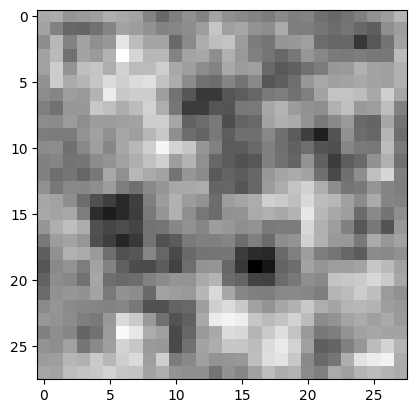

In [6]:
# using the untrained generator to generate an image from random noise
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

**Discriminator**

In [7]:
# Discriminator with Minibatch Discrimination and Spectral Normalization
from tensorflow.keras.layers import SpectralNormalization

def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(SpectralNormalization(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1])))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(SpectralNormalization(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Minibatch Discrimination (Simplified Implementation)
    model.add(layers.Flatten())
    model.add(layers.Dense(128))  # Intermediate layer for minibatch discrimination
    model.add(layers.LeakyReLU())
    model.add(layers.Dense(1))

    return model

In [8]:
# using the untrained discriminator to predict whether an image is real or fake
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00973885]], shape=(1, 1), dtype=float32)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Loss and Optimizer

In [9]:
# Loss Functions with Label Smoothing
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

**Discrimnator Loss**

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [10]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output) * 0.9, real_output)  # Label smoothing for real images
    fake_loss = cross_entropy(tf.zeros_like(fake_output) * 0.1, fake_output)  # Label smoothing for fake images
    total_loss = real_loss + fake_loss
    return total_loss

**Generator Loss**

The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, compare the discriminators decisions on the generated images to an array of 1s.

In [11]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

The discriminator and the generator optimizers are different since we will train two networks separately.

In [12]:
generator_optimizer = tf.keras.optimizers.Adam(LEARNING_RATE_G,beta_1=0.5, beta_2=0.999)
discriminator_optimizer = tf.keras.optimizers.Adam(LEARNING_RATE_D, beta_1=0.5, beta_2=0.999)

**Saving the checkpoints**

In [13]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

**Defining the training loop**

In [14]:
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [15]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

**Generate and save images**

In [16]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

# **Training** **loop**

In [38]:
history = {"loss": [], "accuracy": []}  # Initialize history dictionary

def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        epoch_loss = 0  # Track loss per epoch

        for image_batch in dataset:
            train_step(image_batch)

            # Track generator loss
            noise = tf.random.normal([BATCH_SIZE, noise_dim])
            generated_images = generator(noise, training=False)
            fake_output = discriminator(generated_images, training=False)
            epoch_loss += generator_loss(fake_output).numpy()

        history["loss"].append(epoch_loss / len(dataset))  # Average loss
        history["accuracy"].append(1 - (epoch_loss / len(dataset)))  # Fake accuracy metric

        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)

        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Time: {time.time()-start:.2f} sec")

    # Save history after training
    np.save("training_history.npy", history)


# **Training the model**

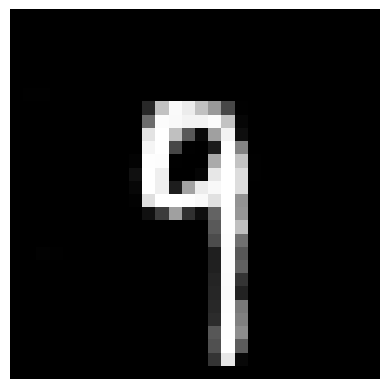

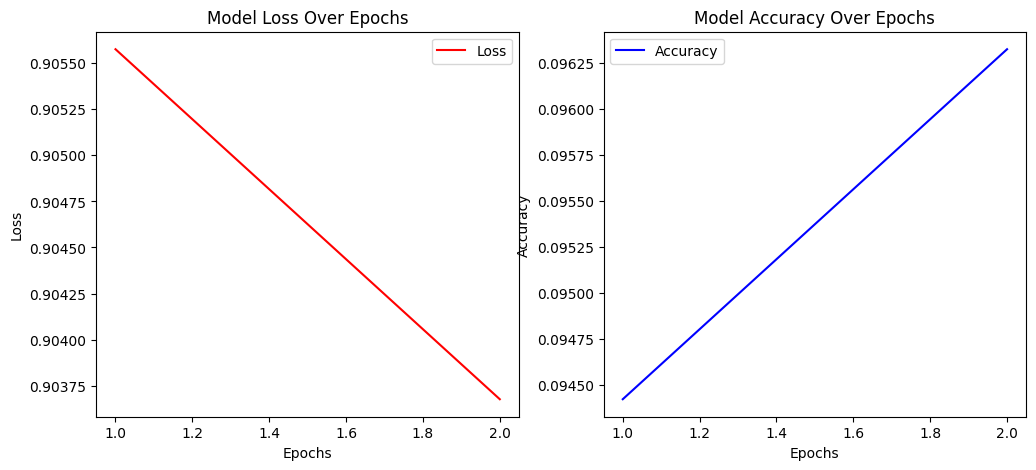

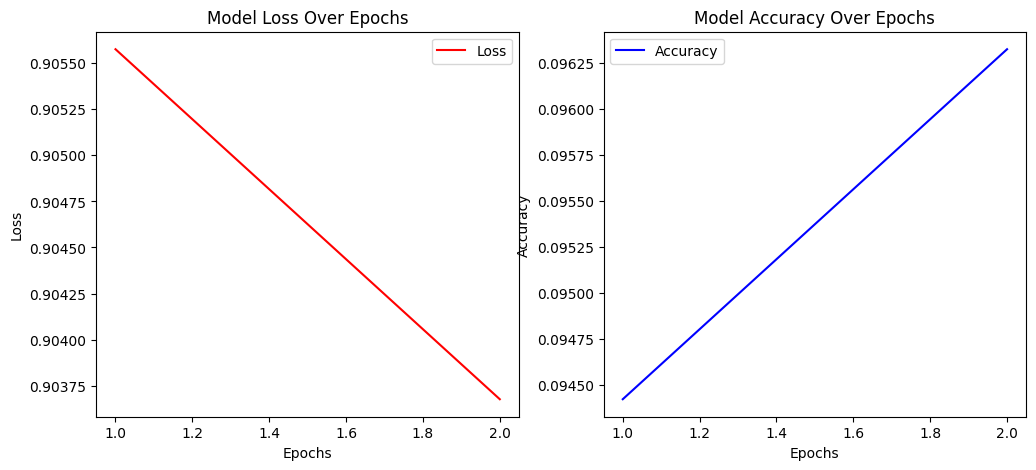

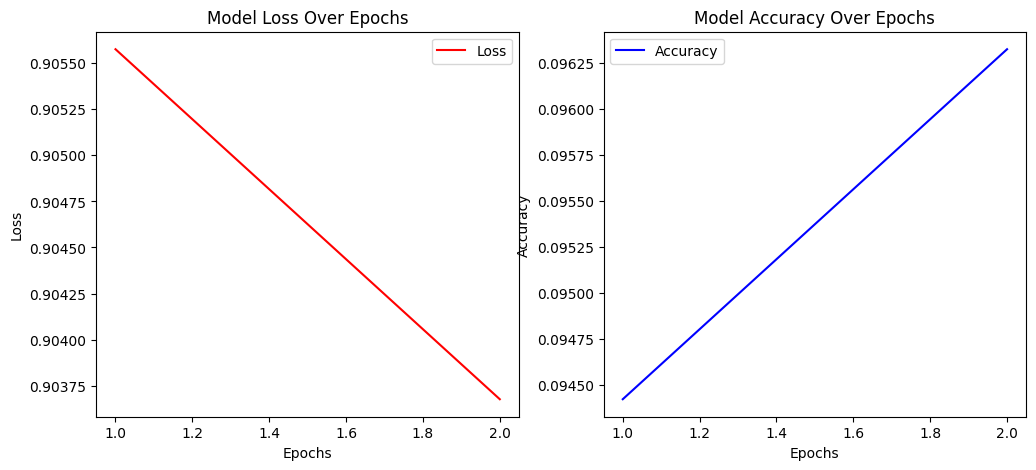

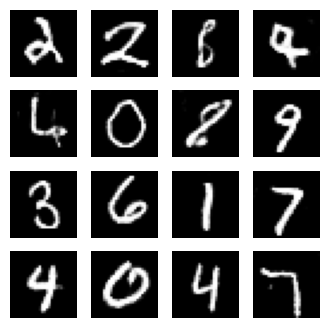

Epoch 1, Loss: 420.7634, Time: 34.62 sec


In [59]:
train_dataset = load_mnist()
train(train_dataset, 1)

# Save the model

In [60]:
generator.save("generator_model.keras")
discriminator.save("discriminator_model.keras")
print("Models saved successfully in Keras format!")

Models saved successfully in Keras format!


# Loading Model

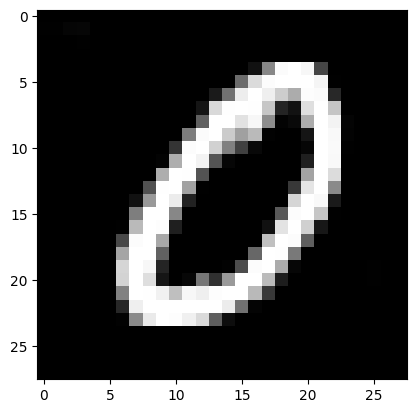

Model loaded and tested successfully!


In [61]:
from tensorflow.keras.models import load_model

# Load the generator model
loaded_generator = load_model("generator_model.keras")

# Generate a new image using the loaded model
noise = tf.random.normal([1, 100])
generated_image = loaded_generator(noise, training=False)

# Display the generated image
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.show()

print("Model loaded and tested successfully!")


In [62]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

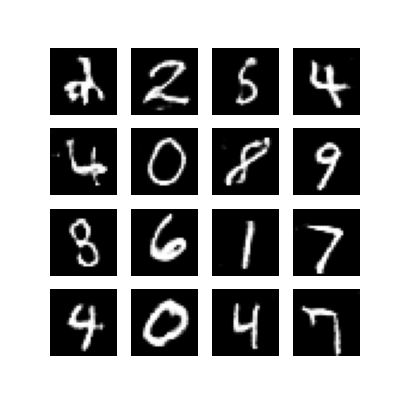

In [63]:
display_image(EPOCHS)

In [29]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.3/51.3 MB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 80.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 5.7 MB/s eta 0:00:00


In [57]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import gradio as gr
import matplotlib.pyplot as plt

# Check if GPU is available
device = "/GPU:0" if tf.config.list_physical_devices('GPU') else "/CPU:0"

# Load the trained model
with tf.device(device):
    generator_model = keras.models.load_model("generator_model.keras")

print(f"✅ Model loaded successfully on {device}")

# Function to generate digits
def generate_digit(digit=None):
    if digit is None:
        digit = np.random.randint(0, 10)  # Random digit between 0-9
    digit = np.clip(digit, 0, 9)  # Ensure valid digit

    latent_dim = 100  # Assuming 100D latent space
    random_noise = np.random.randn(1, latent_dim)

    # Generate digit
    with tf.device(device):
        generated_image = generator_model.predict([random_noise, np.array([digit])])

    # Reshape & normalize image
    generated_image = generated_image.reshape(28, 28) * 255

    # Plot image
    fig, ax = plt.subplots()
    ax.imshow(generated_image, cmap="gray")
    ax.axis("off")

    return fig  # Return plot for Gradio display

# Function to analyze model performance
def analyze_performance():
    try:
        history = np.load("training_history.npy", allow_pickle=True).item()  # Load saved history

        if not history or "loss" not in history or "accuracy" not in history:
            return "No valid performance data found!"

        loss, accuracy = history["loss"], history["accuracy"]
        epochs = range(1, len(loss) + 1)

        fig, ax = plt.subplots(1, 2, figsize=(12, 5))

        ax[0].plot(epochs, loss, "r-", label="Loss")
        ax[0].set_title("Model Loss Over Epochs")
        ax[0].set_xlabel("Epochs")
        ax[0].set_ylabel("Loss")
        ax[0].legend()

        ax[1].plot(epochs, accuracy, "b-", label="Accuracy")
        ax[1].set_title("Model Accuracy Over Epochs")
        ax[1].set_xlabel("Epochs")
        ax[1].set_ylabel("Accuracy")
        ax[1].legend()

        return fig  # Return figure to Gradio

    except Exception as e:
        return f"Error: {e}"  # Return error message if something goes wrong


# Create Gradio UI
with gr.Blocks() as demo:
    gr.Markdown("# ✍️ Handwritten Digit Generator")
    gr.Markdown("Generate a **random** or **specific** handwritten digit using AI! 🚀")

    with gr.Row():
        btn_random = gr.Button("🎲 Generate Random Digit")
        num_input = gr.Number(label="Enter Digit (0-9)", value=0, minimum=0, maximum=9)
        btn_specific = gr.Button("🎯 Generate Specific Digit")

    output_image = gr.Plot()

    btn_random.click(generate_digit, inputs=None, outputs=output_image)
    btn_specific.click(generate_digit, inputs=num_input, outputs=output_image)

    gr.Markdown("## 📊 Model Performance Analysis")
    btn_analysis = gr.Button("📈 Show Performance")
    output_analysis = gr.Plot()

    btn_analysis.click(analyze_performance, inputs=None, outputs=output_analysis)

# Launch app
demo.launch(share=True)


✅ Model loaded successfully on /GPU:0
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://2df1e00aa433cbf78e.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
